In [1]:
%load_ext autoreload
%autoreload 2

# Loading neural data
Here, I will explain how to load neural data with python.

## Data Description
by running the following cell, we'll be able to see the neural data that we have for this project.

In [4]:
!ls /scratch/soroush1/idiosyncrasy/neural_data/

bento_nano_COCO.h5	kar2018_cocobehavior	   many_monkeys.h5
bento_nano_COCO_old.h5	kk_temporal_data.h5	   rates_magneto_active.h5
hvm640			MajajHong2015.h5	   rates_magneto_passive.h5
i1_hvm640.mat		many_monkeys2.h5	   SachiMajajHong2015.h5
i1n_hvm640.mat		many_monkeys2_nolabels.h5


In [17]:
# How to read the .h5 file
import h5py

neural_type = "active"

neural_data_path = f"/scratch/soroush1/idiosyncrasy/neural_data/rates_magneto_{neural_type}.h5"
monkey_name = f"magneto/{neural_type}"
monkey_data = None

with h5py.File(neural_data_path, 'r') as f:
    print(f"{list(f.keys()) = }")
    # Print structure of the data
    def print_structure(name, obj):
        print(name, type(obj))
        if isinstance(obj, h5py.Group):
            for key in obj.keys():
                print(f"  {key}")
    
    f.visititems(print_structure)
    
    # Get the data
    monkey_data = f[monkey_name][:]
    print("Dataset shape:", monkey_data.shape) # time images neural-sites reps

list(f.keys()) = ['magneto']
magneto <class 'h5py._hl.group.Group'>
  active
magneto/active <class 'h5py._hl.dataset.Dataset'>
Dataset shape: (26, 1320, 288, 70)


In [6]:
import h5py
from functions import neuron_reliability, reliability_filtering, regression_indices, model_reliability_2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, RidgeCV
from scipy.stats import sem, pearsonr, ttest_rel, zscore

In [7]:
n_bins, n_imgs, n_neural_sites, n_reps = monkey_data.shape
print(f"n_bins: {n_bins}")
print(f"n_imgs: {n_imgs}")
print(f"n_neural_sites: {n_neural_sites}")
print(f"n_reps: {n_reps}")

n_bins: 26
n_imgs: 1320
n_neural_sites: 288
n_reps: 70


In [8]:
# getting 70-170 ms for S5
monkey_neural = np.nanmean(monkey_data[7:17,:,:,:],axis=0) # gets the neural data for 70-170 ms only, raised a mean of an empty slice warning bc last couple of reps are empty
monkey_neural.shape

(1320, 288, 70)

In [9]:
# get the neuron reliabilities for 70-170 ms
rel, std_rel = neuron_reliability(monkey_neural)
print(f"{rel.shape = }")
print(f"{std_rel.shape = }")

rel.shape = (288,)
std_rel.shape = (288,)


Text(0, 0.5, 'pearson r')

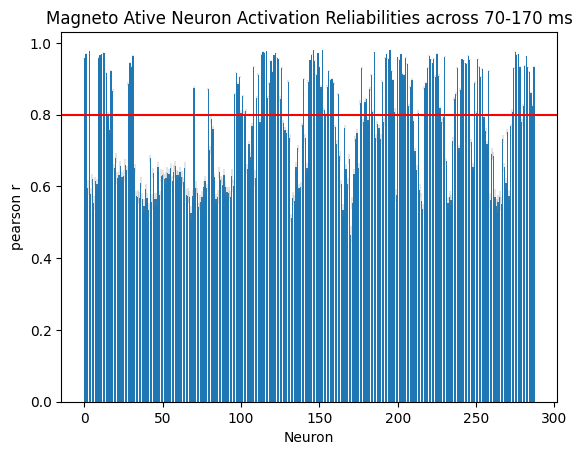

In [10]:
# plot the neuron reliabilities
plt.bar(range(rel.shape[0]),rel,yerr=std_rel, error_kw=dict(ecolor='grey',alpha=0.2))
plt.axhline(y=0.8,color='r')
plt.title('Magneto Ative Neuron Activation Reliabilities across 70-170 ms')
plt.xlabel('Neuron')
plt.ylabel('pearson r')

# Create Dataloader and datamodule for RatedMagnetoActive

In [10]:
import os
import sys

# Add the parent directory to the Python path
script_dir = os.path.dirname(os.getcwd())  # Get the directory where the script is located
parent_dir = os.path.dirname(script_dir)  # Get the parent directory

print(f"{script_dir = }")
print(f"{parent_dir = }")

sys.path.append(parent_dir)

from lightning import LightningDataModule
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
import torch

import argparse
import numpy as np
import h5py

from cka_reg import DATA_PATH
from cka_reg.datamodules.datamodules_utils import *

script_dir = '/lustre06/project/6067616/soroush1/idiosyncrasy/notebooks'
parent_dir = '/lustre06/project/6067616/soroush1/idiosyncrasy'


In [4]:
class StimuliBaseModule(LightningDataModule):
    def __init__(self, hparams, neuraldataset=None, num_workers=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        neuraldataset = (
            neuraldataset if neuraldataset is not None else hparams.neuraldataset
        )
        num_workers = num_workers if num_workers is not None else hparams.num_workers

        if isinstance(hparams, argparse.Namespace):
            self.hparams.update(vars(hparams))
        else:
            self.hparams.update(hparams)

        hparams = self.hparams
        self.image_size = hparams.image_size
        self.dims = (3, self.image_size, self.image_size)
        self.num_workers = num_workers
        self.batch_size = hparams.batch_size
        self.constructor = SOURCES[neuraldataset](hparams)
        self.n_stimuli = int(1e10) if hparams.stimuli == "All" else int(hparams.stimuli)

        # data augmentation parameters
        self.neural_train_transform = hparams.neural_train_transform
        # self.gn_std = hparams.gaussian_noise
        # self.gb_kernel_size, self.gb_min_max_std = eval(hparams.gaussian_blur)
        self.translate = eval(hparams.translate)
        self.rotate = eval(hparams.rotate)
        self.scale = eval(hparams.scale)
        self.shear = eval(hparams.shear)
        # self.brightness = eval(hparams.brightness)
        # self.contrast = eval(hparams.contrast)
        # self.saturation = eval(hparams.saturation)
        # self.hue = eval(hparams.hue)

    def _get_DataLoader(self, *args, **kwargs):
        return DataLoader(*args, **kwargs)

    def train_transform(self):
        if self.neural_train_transform:
            print("Using transforms on neural training data")
            neural_transforms = [
                transforms.ToPILImage(),
                transforms.Resize(self.image_size),
                transforms.RandomAffine(
                    degrees=self.rotate,
                    translate=self.translate,
                    scale=self.scale,
                    shear=self.shear,
                    fill=127,
                ),
                # transform_lib.ColorJitter(
                #    brightness=self.brightness,
                #    contrast=self.contrast,
                #    saturation=self.saturation,
                #    hue=self.hue
                # ),
                transforms.ToTensor(),
                # transform_lib.Lambda(lambda x : x + ch.randn_like(x)*self.gn_std),
                # transform_lib.GaussianBlur(self.gb_kernel_size, sigma=self.gb_min_max_std),
                # imagenet_normalization(),
            ]
        else:
            print("No transforms on neural training data")
            neural_transforms = [
                transforms.ToPILImage(),
                transforms.Resize(self.image_size),
                transforms.ToTensor(),
            ]

        preprocessing = transforms.Compose(neural_transforms)

        return preprocessing

    def val_transform(self):
        preprocessing = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize(self.image_size),
                transforms.ToTensor(),
                # imagenet_normalization(),
            ]
        )

        return preprocessing

    def get_stimuli(self, stimuli_partition):
        """
        Stimuli are always the same, it's the target that changes
        """
        X = self.constructor.get_stimuli(stimuli_partition=stimuli_partition).astype(
            "float32"
        )[: self.n_stimuli]

        return X

    def get_target(self, stimuli_partition, *args, **kwargs):
        """
        This method is intended to be written over by the inheritting data module classes.
        """
        raise ValueError(
            "The get_target method has not been overwritten on the StimuliBaseModule"
        )

    def train_dataloader(self):
        """
        Uses the train split from provided neural data path
        """
        hparams = self.hparams

        X = self.get_stimuli(stimuli_partition="train")
        Y = self.get_target(
            neuron_partition=0,
            stimuli_partition="train",
            animals=hparams.fit_animals,
            neurons_animal=hparams.neurons_animal,
            n_trials=hparams.trials,
        )

        dataset = CustomTensorDataset((X, *Y), self.train_transform())

        print(self.num_workers)
        loader = self._get_DataLoader(
            dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            drop_last=True,
            pin_memory=True,
        )
        if self.hparams.verbose:
            print(f"neural train set shape: {X.shape}, {[y.shape for y in Y]}")
        return loader

    def val_dataloader(
        self,
        stimuli_partition="test",
        neuron_partition=0,
        neurons_animal=None,
        animals=None,
        batch_size=None,
    ):
        """
        Uses the validation split of neural data
        """
        hparams = self.hparams
        animals = animals if animals is not None else hparams.test_animals
        neurons_animal = (
            neurons_animal if neurons_animal is not None else hparams.neurons_animal
        )
        batch_size = batch_size if batch_size is not None else self.batch_size

        X = self.get_stimuli(stimuli_partition=stimuli_partition)
        Y = self.get_target(
            neuron_partition=neuron_partition,
            stimuli_partition=stimuli_partition,
            animals=animals,
            neurons_animal=neurons_animal,
            n_trials="All",
        )

        dataset = CustomTensorDataset((X, *Y), self.train_transform())

        loader = self._get_DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            drop_last=False,
            pin_memory=True,
        )

        if self.hparams.verbose:
            print(f"neural validation set shape: {X.shape}, {[y.shape for y in Y]}")
        return loader

class NeuralDataModule(StimuliBaseModule):
    ## add control for validation set neurons!
    name = "NeuralData"
    """
    A DataLoader for neural data. Extends StimuliBaseModule and uses a dataconstructer class 
    to format neural data.
    """

    def __init__(self, hparams, *args, **kwargs):
        super().__init__(hparams, *args, **kwargs)
        self.class_type = "category_name"

    def get_target(
        self, neuron_partition, stimuli_partition, animals, neurons_animal, n_trials
    ):
        hparams = self.hparams

        # neural responses
        H = self.constructor.get_neural_responses(
            animals=animals,
            n_neurons_animal=neurons_animal,
            n_trials=n_trials,
            neuron_partition=neuron_partition,
            stimuli_partition=stimuli_partition,
            hparams=hparams,
        ).astype("float32")[: self.n_stimuli]

        if stimuli_partition == "train":
            H = self.control_manipulate(H)

        Y = self.constructor.get_labels(
            stimuli_partition=stimuli_partition, class_type=self.class_type
        )[: self.n_stimuli]

        return (H, Y)

    def control_manipulate(self, H):
        def shuffle(X):
            ntotal = X.shape[0]
            shuffled_inds = np.random.choice(ntotal, ntotal, replace=False)
            return X[shuffled_inds]

        def randn_like(X):
            return np.random.randn(*X.shape)

        if "shuffle" in self.hparams.controls:
            H = shuffle(H)

        if "random" in self.hparams.controls:
            H = randn_like(H)

        if "rank" in self.hparams.controls:
            raise NameError("Rank control not implemented!")

        if "spectrum" in self.hparams.controls:
            raise NameError("spectrum control not implemented!")

        return H


class NeuralDataConstructor:
    def __init__(self, hparams, partition_scheme, *args, **kwargs):
        self.hparams = hparams
        self.partition = Partition(*partition_scheme, seed=hparams.seed)
        self.verbose = hparams.verbose

    def get_stimuli(self, *args, **kwargs):
        # overwrite method with dataset specific operations
        raise NameError("Method not implemented")

    def get_neural_responses(self, *args, **kwargs):
        # overwrite method with dataset specific operations
        raise NameError("Method not implemented")

    def get_labels(self, *args, **kwargs):
        # overwrite method with dataset specific operations
        raise NameError("Method not implemented")

    @staticmethod
    def partition_neurons(X, ntrain, seed=0):
        np.random.seed(seed)
        idx = np.random.choice(X.shape[1], X.shape[1], replace=False)
        return X[:, idx[:ntrain]], X[:, idx[ntrain:]]

In [13]:
class MagnetoNeuralDataConstructor(NeuralDataConstructor):
    def __init__(
        self, 
        hparams, 
        partition_scheme=(1320, 1000, 160, 160), 
        *args, 
        **kwargs
    ):
        super().__init__(hparams, partition_scheme, *args, **kwargs)
        self.data_path = f"{DATA_PATH}/neural_data/rates_magneto_active.h5"
        self.data = h5py.File(self.data_path, "r")
        self.n_heldout_neurons = 0

    def get_stimuli(self, stimuli_partition):
        """Match the original method signature exactly"""
        # Load and process stimuli data
        X = self.data["images"][:].transpose(0, 3, 1, 2) / 255
        # Partition the stimuli
        X_Partitioned = self.partition(X)[stimuli_partition]
        return X_Partitioned

    def get_neural_responses(
        self,
        animals,
        n_neurons_animal,
        n_trials,
        neuron_partition,
        stimuli_partition,
        hparams,
    ):
        """Keep exact same signature as original class"""
        if self.verbose:
            print(
                f"constructing {stimuli_partition} data with\n"
                + f"animals:{animals}\n"
                + f"neurons:{n_neurons_animal}\n"
                + f"trials:{n_trials}\n"
            )

        # Transform "All" to all dataset's animals
        animals = self.expand(animals)
        
        # Handle n_neurons_animal same way as original
        n_neurons_animal = (
            [int(1e10)] * len(animals)
            if (n_neurons_animal == ["All"] or neuron_partition != 0)
            else n_neurons_animal
        )
        n_trials = int(1e10) if n_trials == "All" else int(n_trials)

        print(f"{animals = }")
        print(f"{n_neurons_animal = }")
        
        # Process each animal's data
        neural_responses = []
        for animal, n_neurons in zip(animals, n_neurons_animal):
            r = self._get_neural_responses(animal, n_trials, neuron_partition, hparams)
            selected_neurons = np.random.RandomState(
                hparams.seed_select_neurons
            ).permutation(r.shape[1])[:n_neurons]
            r = r[:, selected_neurons]
            neural_responses.append(r)

        X = np.concatenate(neural_responses, axis=1)

        if self.verbose:
            print(f"Neural data shape:\n(stimuli, sites) : {X.shape}")

        X_Partitioned = self.partition(X)
        print(f"{X_Partitioned.keys() = }")
        X_Partitioned = X_Partitioned[stimuli_partition]
        return X_Partitioned

    def _get_neural_responses(self, animal, n_trials, neuron_partition, hparams):
        """Keep same signature as original private method"""
        animal, region = animal.split("/")
        print(f"{animal = }")
        print(f"{region = }")
        
        X = self.data[f"{animal}/{region}"][:]

        if self.verbose:
            print(
                f"{animal} {region} shape:\n(timestep, stimuli, sites, reps) : {X.shape}"
            )

        # Get mean over time window (using hparams.window like original)
        start, stop = [int(s) for s in hparams.window.split("t")]
        print(f"{start} - {stop}")
        X = np.nanmean(X[start:stop], axis=0)

        if self.verbose:
            print(f"(stimuli, sites, trials) : {X.shape}")

        # Handle neuron partitioning
        X = self.partition_neurons(
            X, X.shape[1] - self.n_heldout_neurons, seed=hparams.seed
        )[neuron_partition]

        if self.verbose:
            print(f"(stimuli, sites, trials) : {X.shape}")

        # Take mean over trials
        X = X[:, :, :n_trials]
        X = np.nanmean(X, axis=2)

        if self.verbose:
            print(f"(stimuli, sites) : {X.shape}")

        assert ~np.isnan(np.sum(X))
        return X

    @staticmethod
    def expand(animals):
        """Keep same static method for consistency"""
        if animals[0] == "All":
            return ["magneto/active"]
        return animals

class Hparams:
    def __init__(self):
        # Time window parameters
        self.window = "7t17"  # 70-170ms time window
        
        # Random seed parameters
        self.seed = 42
        self.seed_select_neurons = 42
        
        # Logging parameters
        self.verbose = True
        
        # Data parameters
        self.n_trials = "All"
        self.n_neurons = "All"
        
        # Path parameters
        self.data_path = "/path/to/your/data"
        
        # Model parameters (if needed)
        self.batch_size = 128
        self.learning_rate = 0.001
        
        # Device parameters
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
# Initialize parameters
hparams = Hparams()

# Create constructor instance
constructor = MagnetoNeuralDataConstructor(hparams)

# Test get_stimuli
# stimuli = constructor.get_stimuli(stimuli_partition=0)
# print("Stimuli shape:", stimuli.shape)

# Test with all animals
all_responses = constructor.get_neural_responses(
    animals=["All"],
    n_neurons_animal=["All"],
    n_trials="All",
    neuron_partition=0,
    stimuli_partition="train",
    hparams=hparams
)
print("All neural responses shape:", all_responses.shape)

constructing train data with
animals:['All']
neurons:['All']
trials:All

animals = ['magneto/active']
n_neurons_animal = [10000000000]
animal = 'magneto'
region = 'active'
magneto active shape:
(timestep, stimuli, sites, reps) : (26, 1320, 288, 70)
7 - 17
(stimuli, sites, trials) : (1320, 288, 70)
(stimuli, sites, trials) : (1320, 288, 70)
(stimuli, sites) : (1320, 288)
Neural data shape:
(stimuli, sites) : (1320, 288)
X_Partitioned.keys() = dict_keys(['train', 'test', 'val'])
All neural responses shape: (1000, 288)


In [ ]:
all_responses.shape